In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('full_df.csv')

In [3]:
df[df['filename'] == '0_right.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg


In [4]:
# This is to show that the dataset separate two image files in two rows
df[df['Left-Fundus'] == '4_left.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
3197,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",4_left.jpg


In [5]:
# check the string slicing 
x = df['filename']
name = x[0][:-4]
name[-4]

'i'

In [6]:
# test imputing the image
y = df['filename'][0]
im = Image.open(f'./0_right_thumbnail.jpg')
# list(im.getdata())

NameError: name 'Image' is not defined

In [7]:
# with open(f'./preprocessed_images/{x}', 'r') as f:
#     print(f)

# The following grabs all the images from the preprocessed_images folder, and create thumbnail to reduce the data size 
from PIL import Image
from tensorflow.keras.preprocessing import image

# create three lists(all, left, right) for the model later
all_images = []
all_images_left = []
all_images_right = []
def get_pixels(values):
    im = Image.open(f'./preprocessed_images/{values}')
    name = values[:-4]
    im.thumbnail((128,128))
    all_images.append(im)
    if name[-5] == 'r':
        all_images_right.append(im)
    else:
        all_images_left.append(im)
    return im

df['pixel_data'] = df['filename'].apply(lambda x: get_pixels(x))

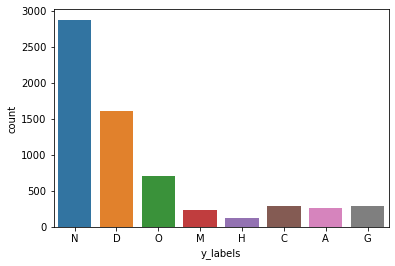

In [10]:
# countplot to show the distribution of the dataset
import seaborn as sns
sns.countplot(df['y_labels'])

In [8]:
df = df.drop('filepath', axis=1)

In [9]:
# create two y labeling methods for different models later on
def y_labels(label):
    return label[2]

def simplify(label):
    if label[2] == 'N':
        return 0
    else:
        return 1
    
df['y_labels'] = df['labels'].apply(lambda x: y_labels(x))
df['bin_labels'] = df['labels'].apply(lambda x: simplify(x))
df.head(1)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,labels,target,filename,pixel_data,y_labels,bin_labels
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,N,0


In [11]:
# check if the data is balanced enough, seems ok in this case
df['bin_labels'].value_counts()

1    3519
0    2873
Name: bin_labels, dtype: int64

In [12]:
# change the image data into array 
for img in range(len(all_images)):
    all_images[img] = image.img_to_array(all_images[img])
    all_images[img] = all_images[img]/255
image_array = np.array(all_images)

In [13]:
image_array.shape

(6392, 128, 128, 3)

In [14]:
for img in range(len(all_images_left)):
    all_images_left[img] = image.img_to_array(all_images_left[img])
for img in range(len(all_images_right)):
    all_images_right[img] = image.img_to_array(all_images_right[img])

In [15]:
image_array_l = np.array(all_images_left)
image_array_r = np.array(all_images_right)

In [16]:
image_array.shape

(6392, 128, 128, 3)

In [17]:
# find the index number where the left eye image starts
y = df['y_labels'][3194:]
len(y)

3198

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from skimage import io

# x_train = np.array(all_images)
# X_unprocessed = df['pixel_data']
# transformer = ImageDataGenerator(rescale=3.0/255.)
# X = transformer.flow_from_dataframe(df, x_col=X_unprocessed, batch_size=20, target_size=(128,128))
# print(X.shape)
# print(X[0])

y = df['y_labels']

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_y)

binary_y = df['bin_labels']
binary_y = utils.to_categorical(binary_y)

X_train, X_test, y_train, y_test = train_test_split(image_array, binary_y, test_size=0.25)

In [19]:
dummy_y[0]

array([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [20]:
print(X_train.shape)
print(y_train.shape)

(4794, 128, 128, 3)
(4794, 2)


## The first model
using softmax as the last activation function, num_classes should be changed when creating different models

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 2

cnn = Sequential()
cnn.add(Conv2D(25,(3,3),
              activation='relu',
              input_shape=(128,128,3)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Conv2D(50,(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(num_classes, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 25)      700       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 25)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 50)        11300     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               5760128   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

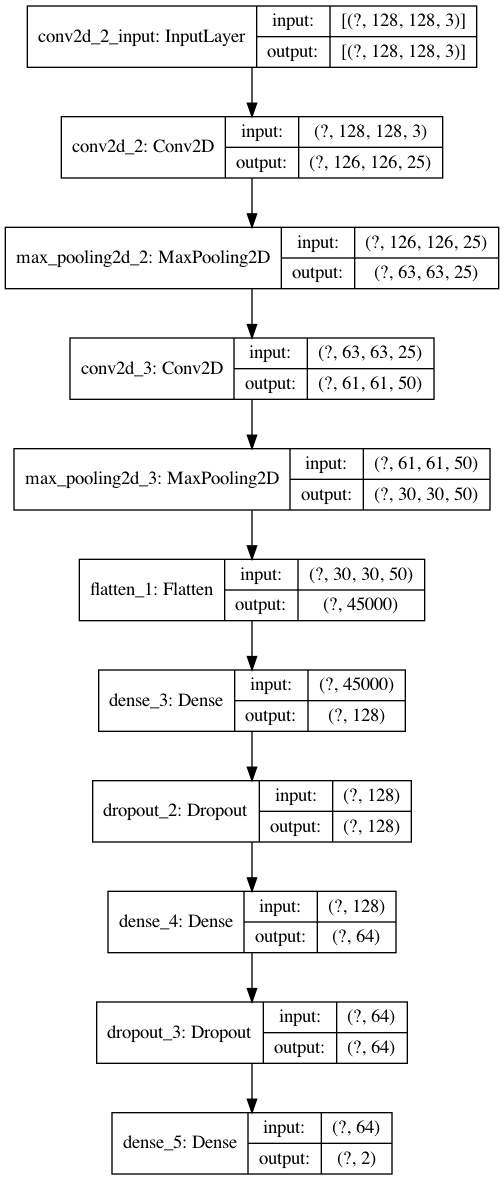

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(cnn, show_shapes=True, show_layer_names=True, to_file='binary_model.png')

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

### The best accuracy for binary in this model is 55%, for multi-categories is around 46%

In [27]:
batch_size=30
epochs=10

cnn.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_split=0.2,
       callbacks=[early_stop])

Epoch 1/10
128/128 [==============================] - 22s 175ms/step - loss: 0.6991 - accuracy: 0.5536 - precision: 0.5505 - recall: 0.5559 - val_loss: 0.6848 - val_accuracy: 0.5589 - val_precision: 0.5589 - val_recall: 0.5589
Epoch 2/10
128/128 [==============================] - 24s 185ms/step - loss: 0.6859 - accuracy: 0.5528 - precision: 0.5535 - recall: 0.5528 - val_loss: 0.6852 - val_accuracy: 0.5589 - val_precision: 0.5589 - val_recall: 0.5589
Epoch 3/10
128/128 [==============================] - 22s 171ms/step - loss: 0.6846 - accuracy: 0.5578 - precision: 0.5585 - recall: 0.5601 - val_loss: 0.6858 - val_accuracy: 0.5610 - val_precision: 0.5604 - val_recall: 0.5610
Epoch 4/10
128/128 [==============================] - 22s 169ms/step - loss: 0.6812 - accuracy: 0.5598 - precision: 0.5618 - recall: 0.5617 - val_loss: 0.6819 - val_accuracy: 0.5662 - val_precision: 0.5650 - val_recall: 0.5662
Epoch 5/10
128/128 [==============================] - 22s 174ms/step - loss: 0.6802 - accura

In [32]:
y_predict = cnn.predict_classes(X_test)
np.where(y_predict == 1)

(array([ 197,  229,  250,  284,  478,  482,  524,  532,  568,  621,  646,
         671,  808,  848,  898, 1279, 1492]),)

In [28]:
score = cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.684592604637146
Test accuracy: 0.5675844550132751


## The second model
the very first model - using sigmoid as the last activation function, nodes are set to 8 currently

In [29]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(X_train,y_train, epochs=10, batch_size=20)

Epoch 1/10
240/240 [==============================] - 25s 106ms/step - loss: 0.6858 - accuracy: 0.5528
Epoch 2/10
240/240 [==============================] - 25s 105ms/step - loss: 0.6824 - accuracy: 0.5544
Epoch 3/10
240/240 [==============================] - 26s 106ms/step - loss: 0.6810 - accuracy: 0.5574
Epoch 4/10
240/240 [==============================] - 26s 109ms/step - loss: 0.6795 - accuracy: 0.5674
Epoch 5/10
240/240 [==============================] - 26s 108ms/step - loss: 0.6778 - accuracy: 0.5755
Epoch 6/10
240/240 [==============================] - 26s 108ms/step - loss: 0.6759 - accuracy: 0.5872
Epoch 7/10
240/240 [==============================] - 27s 110ms/step - loss: 0.6732 - accuracy: 0.5880
Epoch 8/10
240/240 [==============================] - 26s 108ms/step - loss: 0.6735 - accuracy: 0.5891
Epoch 9/10
240/240 [==============================] - 26s 106ms/step - loss: 0.6713 - accuracy: 0.5864
Epoch 10/10
240/240 [==============================] - 26s 107ms/step - l

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6758501529693604
Test accuracy: 0.5738422870635986


## The third model
reference - https://www.kaggle.com/roobansappani/cataract-detection
saw this notebook and it got 93% of accuracy, so I decided to test on the binary case
the model takes a LONG time to fit(check the seconds), I only train for 10 epochs in the following model
### got an accuracy of 63%, could possibly get higher

In [495]:
from tensorflow.keras.applications import VGG19

vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(128, 128, 3))
for layer in vgg.layers:
    layer.trainable = False

model_1 = Sequential()
model_1.add(vgg)
model_1.add(Flatten())
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(2,activation = "softmax"))
model_1.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [497]:
model_1.fit(X_train, y_train, 
            validation_split = 0.2, 
            epochs = 18,
            batch_size = 30,
           callbacks=[early_stop])

Epoch 1/10
30/30 [==============================] - 176s 6s/step - loss: 0.6892 - accuracy: 0.5437 - precision: 0.5437 - recall: 0.5437 - val_loss: 0.6793 - val_accuracy: 0.5902 - val_precision: 0.5902 - val_recall: 0.5902
Epoch 2/10
30/30 [==============================] - 176s 6s/step - loss: 0.6716 - accuracy: 0.5739 - precision: 0.5739 - recall: 0.5739 - val_loss: 0.6759 - val_accuracy: 0.5673 - val_precision: 0.5673 - val_recall: 0.5673
Epoch 3/10
30/30 [==============================] - 177s 6s/step - loss: 0.6739 - accuracy: 0.5718 - precision: 0.5718 - recall: 0.5718 - val_loss: 0.6813 - val_accuracy: 0.5485 - val_precision: 0.5485 - val_recall: 0.5485
Epoch 4/10
30/30 [==============================] - 177s 6s/step - loss: 0.6578 - accuracy: 0.5911 - precision: 0.5911 - recall: 0.5911 - val_loss: 0.6924 - val_accuracy: 0.5652 - val_precision: 0.5652 - val_recall: 0.5652
Epoch 5/10
30/30 [==============================] - 176s 6s/step - loss: 0.6514 - accuracy: 0.5958 - precisi

In [ ]:
score = model_1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [11]:
df_excel = pd.read_excel('./ODIR-5K/ODIR-5K/data.xlsx', sheet_name='Sheet1')

In [98]:
df_excel

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
